In [1]:
# ============================================================
# Notebook setup
# ============================================================

%load_ext autoreload
%autoreload 2

import logging

import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from scipy import signal
%matplotlib inline

import semg_bss

# Configure log file
LOG_FILE = "semg_bss.log"
logging.basicConfig(filename=LOG_FILE, encoding='utf-8', level=logging.INFO, filemode="w")

DATA_DIR = "/home/nihil/Scrivania/putemg-downloader/Data-HDF5"
FS_EMG = 5120  # sampling frequency
RE_FS = FS_EMG // 2  # resampling frequency
MAX_COMP = 25  # target number of components
SIL = 0.85
SEED = 42

# Decomposition of sEMG Signals and Gesture Classification with SNNs
The aim of this project is to decompose a sEMG signal of a gesture, obtain the MUAPs, and then classify the gesture with a Spiking Neural Network (SNN). In particular, we'll train the decomposition model once on a training signal, which must be sufficiently informative about the gesture we want to recognize (*offline calibration*). Then, we'll reuse the decomposition model to transform new signals and classify them (*online analysis*).

## 1. Introduction to ICA-based Blind Source Separation
The original ICA formulation from [Hyvarinen et al.](https://www.cs.helsinki.fi/u/ahyvarin/papers/NN00new.pdf) relies on instantaneous mixing:

$\mathbf{X} = \mathbf{A}\mathbf{S}$

where

- $\mathbf{X}$ is the $N_\text{recording} \times N_\text{samples}$ matrix of observables (i.e. the sEMG recording);
- $\mathbf{S}$ is the $N_\text{components} \times N_\text{samples}$ matrix of the original signals (i.e. the MUAPs);
- $\mathbf{A}$ is the $N_\text{recording} \times N_\text{components}$ mixing matrix.

The FastICA algorithm was developed to address this formulation.

However, since the muscle fibers act as a low-pass filter, the resulting sEMG signal is a convolutive mixture of the MUAPs ([Holobar et al.](https://ieeexplore.ieee.org/document/4291854)):

$x_i(k)=\sum_{l=0}^{L-1} \sum_{j=1}^N h_{ij}(l)s_j(k-l)+n_i(k);\;\;\;\;i=1,\dots,M$

namely the matrix of electrode recordings $\mathbf{X}$ is obtained by performing a 1D convolution between a mixing filter $\mathbf{H}$ with size $L$ and the actual spike trains $\mathbf{S}$.

[Thomas et al.](https://ieeexplore.ieee.org/document/1605245) adapted FastICA in order to address convolutive mixtures.

## 2. putEMG dataset
This dataset contains the sEMG recordings of 44 subjects, acquired while they were performing 7 hand gestures (in addition to rest and idle gestures), during two recording sessions. In particular, the dataset provides 3 type of signals:

- **repeats_long**: subjects were instructed to perform 7 action blocks, where each block contains 8 repetitions of each active gesture.
- **repeats_short**: subjects were instructed to perform 7 action blocks, where each block contains 6 repetitions of each active gesture.
- **sequential**: subjects were instructed to perform 6 action blocks, where each block is a subsequent exectution of all active gestures.

The sEMG data were collected using 24 electrodes, with a sampling rate of 5120 Hz.

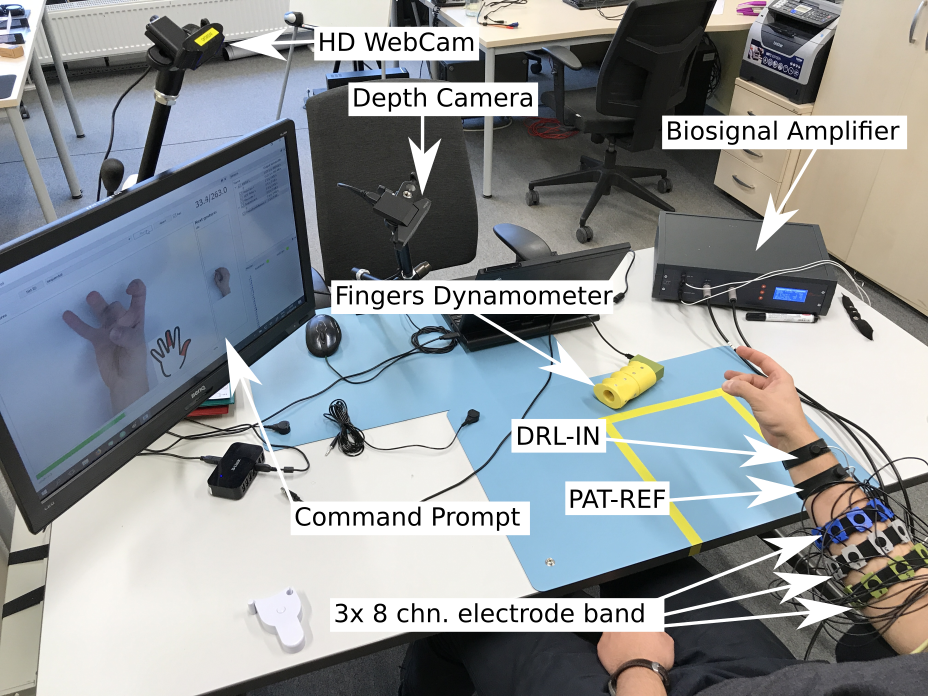

## 3. Decomposition
For now we will focus on the first subject and on the first session: first of all, let's visualize the repeats_long signal, that we'll use to calibrate the decomposition model.

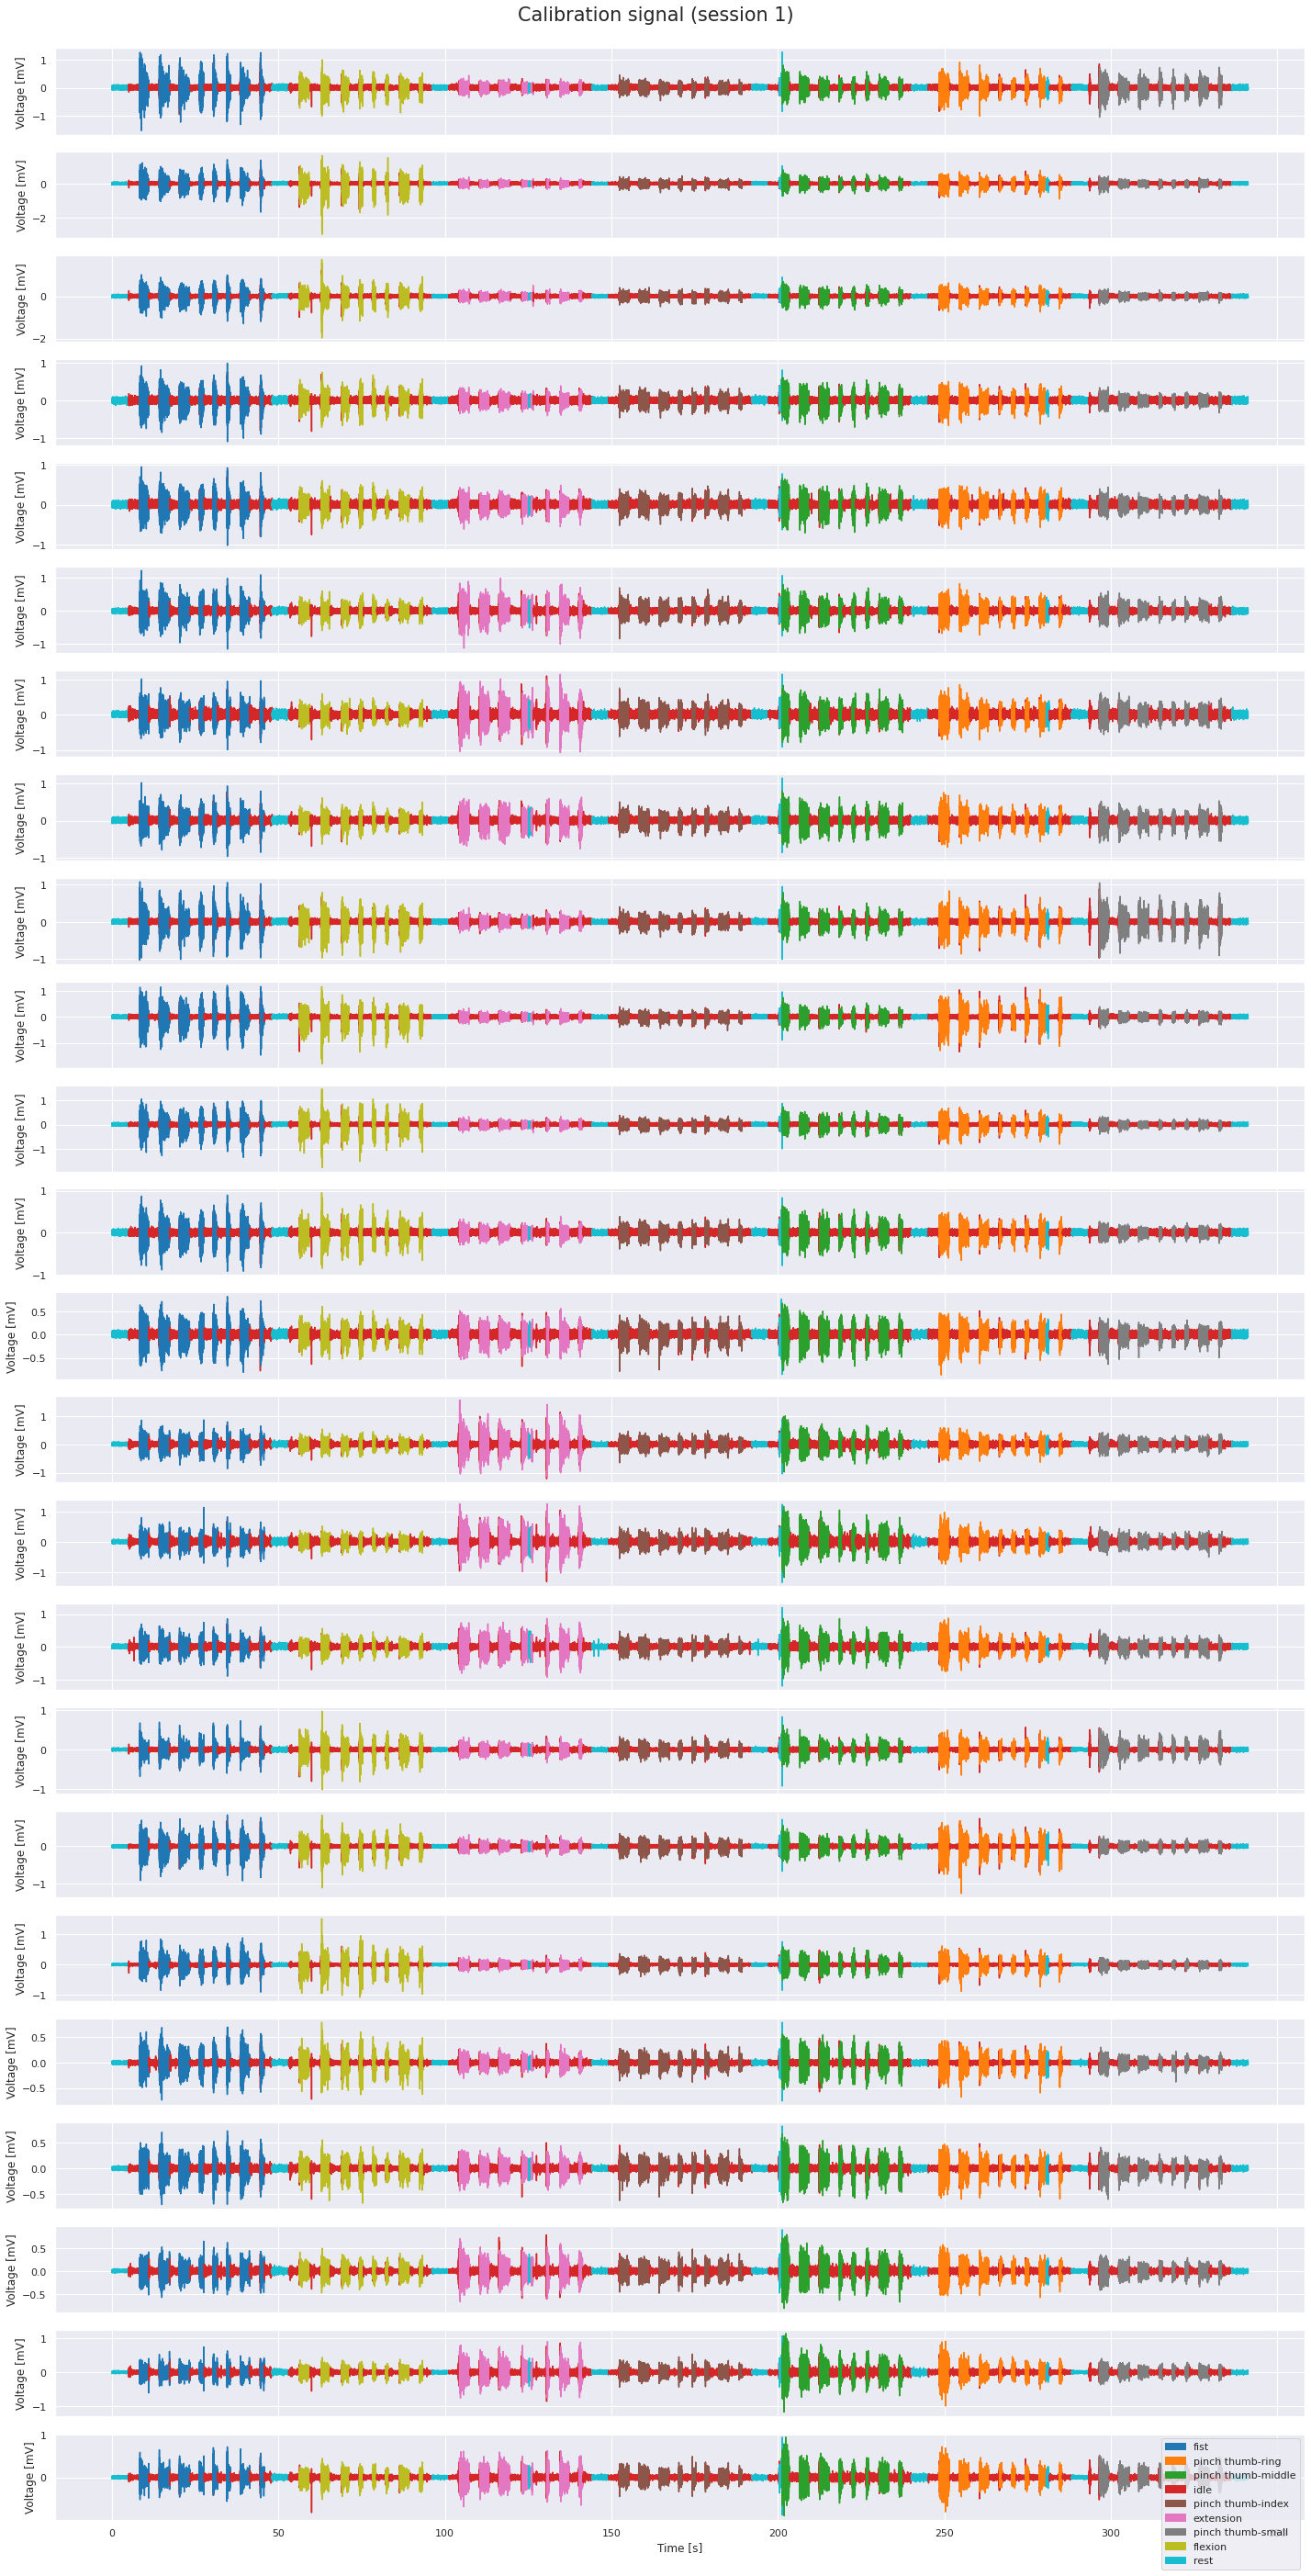

In [2]:
# Load signal
emg_calib_s1, labels_calib_s1 = semg_bss.put_emg.load_put_emg(
    DATA_DIR,
    subject=3,
    session=1,
    task_type="repeats_long"
)

# Filter it with 20-700 Hz band-pass filter + notch filter
emg_calib_s1 = semg_bss.preprocessing.filter_signal(
    emg_calib_s1,
    fs=FS_EMG,
    min_freq=20,
    max_freq=700,
    notch_freqs=[30, 50, 90, 60, 150],
    order=5
)

# Resample at 2.5 kHz
secs = emg_calib_s1.shape[1] / FS_EMG
n_samples = int(secs * RE_FS)
emg_calib_s1 = signal.decimate(emg_calib_s1, FS_EMG // RE_FS, axis=1)
for i in range(len(labels_calib_s1)):
    # Get boundaries for current label
    l, old_from, old_to = labels_calib_s1[i]
    # Convert them to new sampling frequency
    new_from = int(old_from / FS_EMG * RE_FS)
    new_to = int(old_to / FS_EMG * RE_FS)
    # Save them
    labels_calib_s1[i] = (l, new_from, new_to)

# Plot it
semg_bss.plot_signal(
    emg_calib_s1,
    fs=RE_FS,
    title="Calibration signal (session 1)",
    labels=labels_calib_s1,
    fig_size=(20, 40)
)

To simplify the classification, let's focus on fewer gestures: in particular, we'll work on flexion and extension, and thus we'll keep only the slice from second 50 to 150.

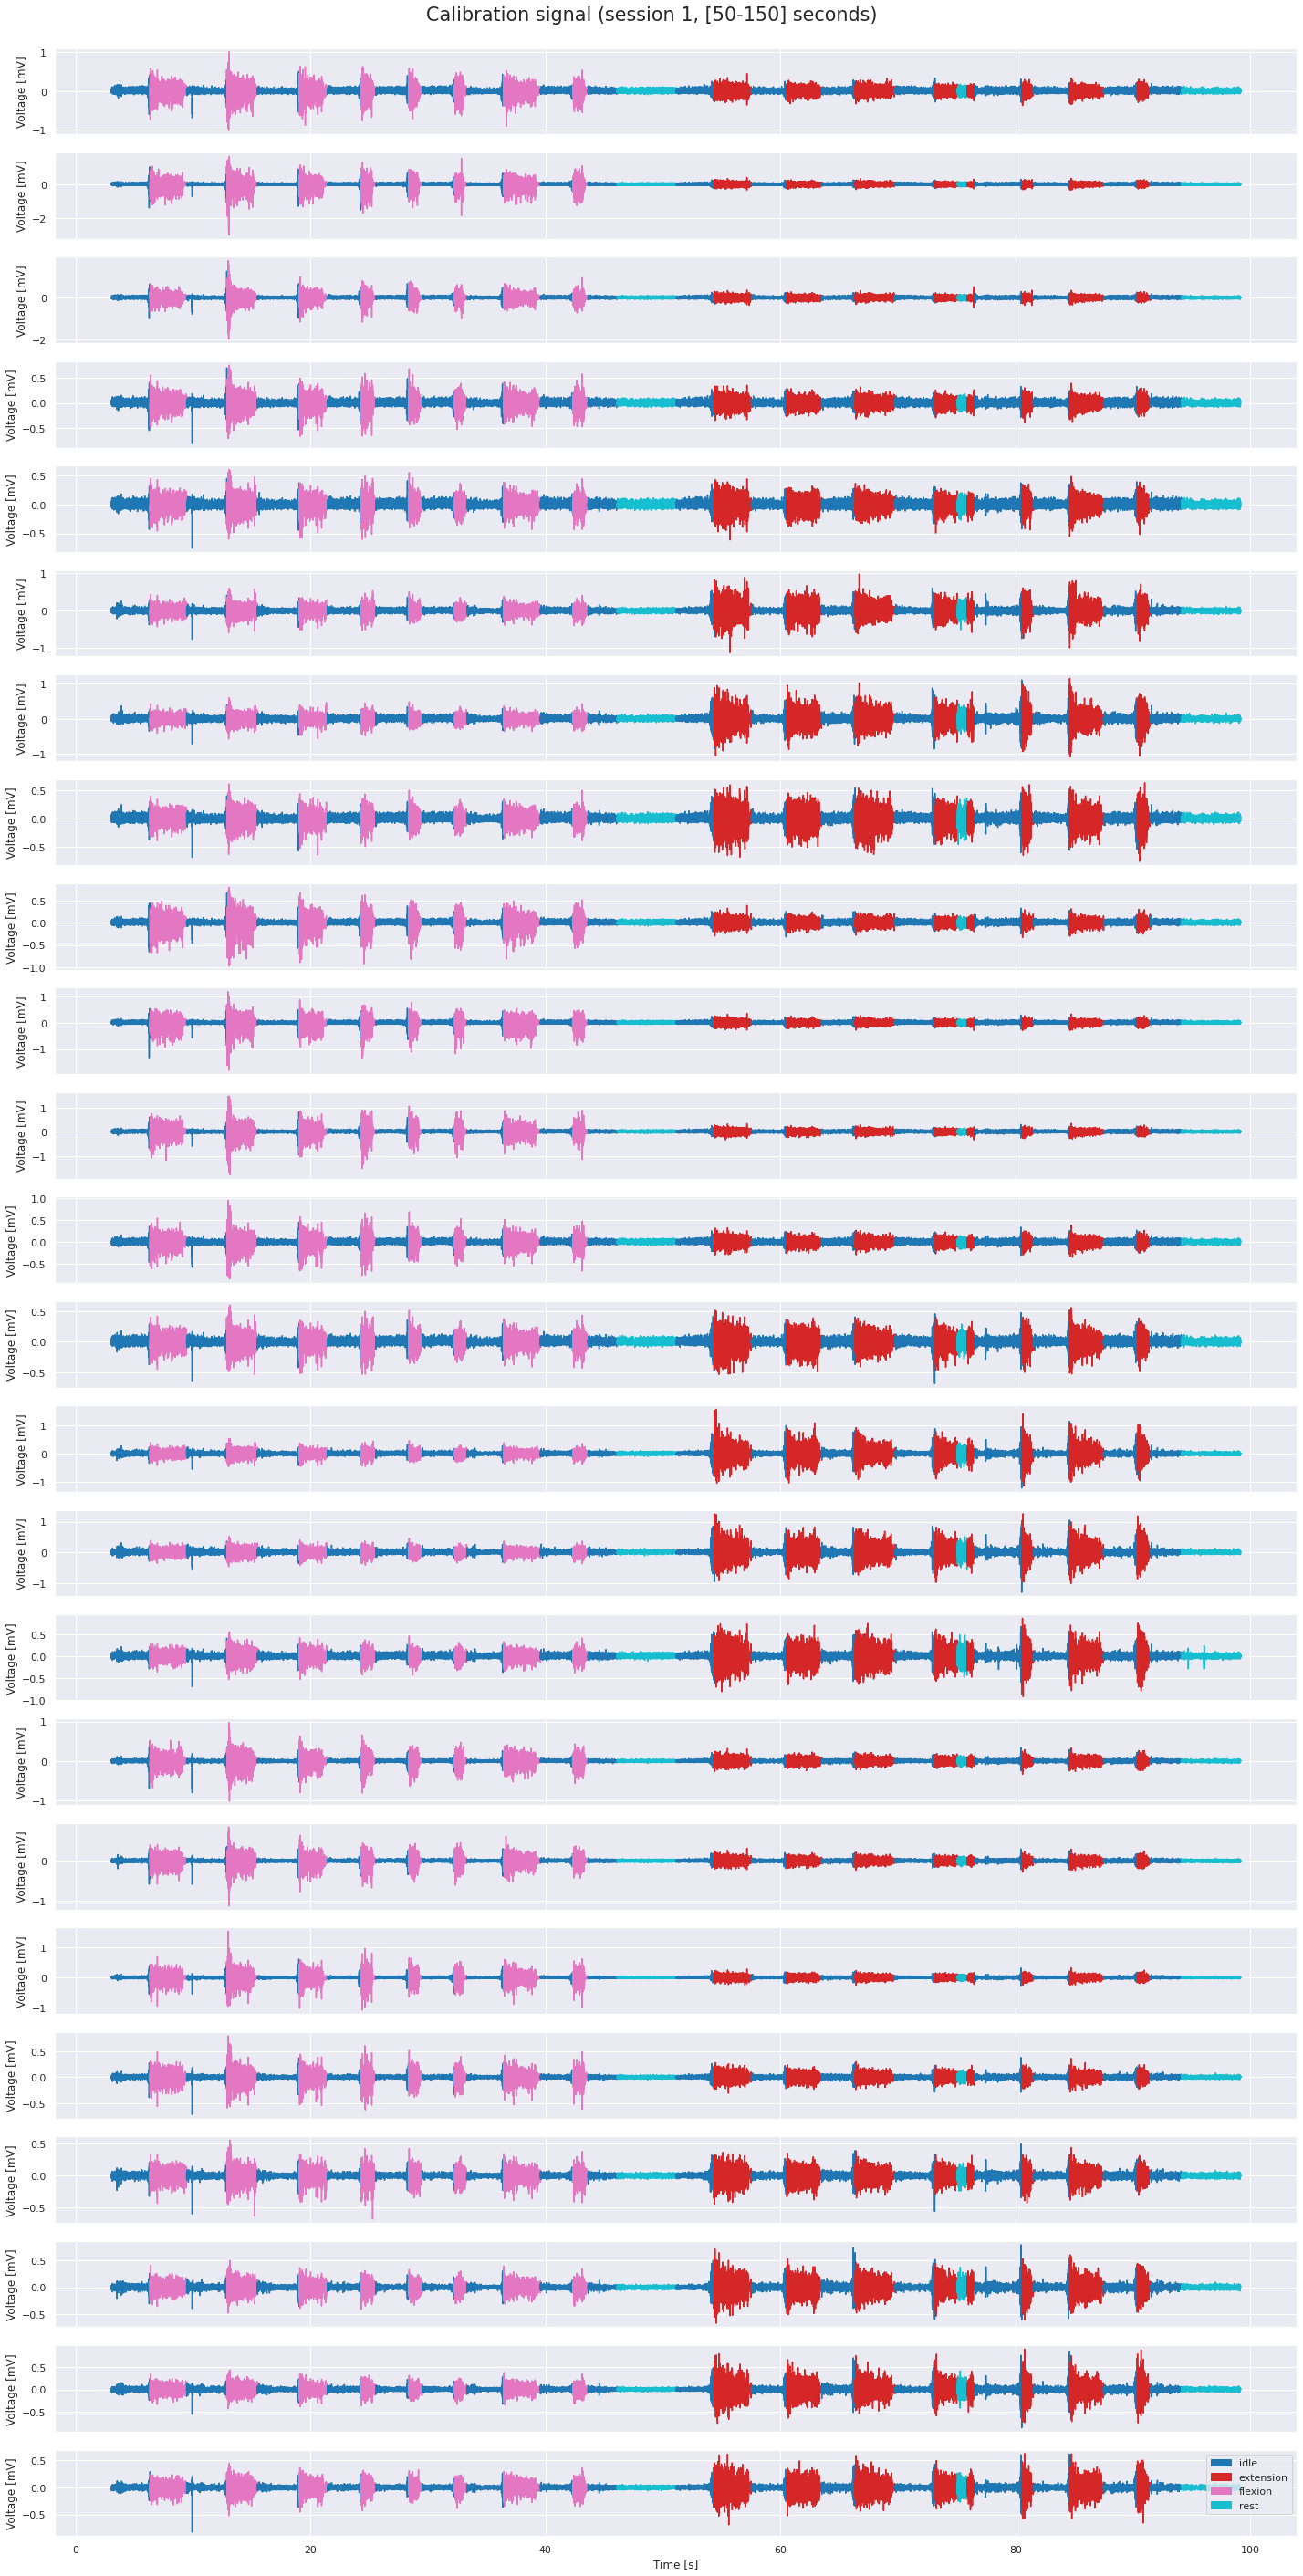

In [3]:
cut_from = 50 * RE_FS
cut_to = 150 * RE_FS
emg_calib_s1 = emg_calib_s1[:, cut_from:cut_to]
labels_calib_s1 = [(l, l_from - cut_from, l_to - cut_from) for l, l_from, l_to in labels_calib_s1 if l_from >= cut_from and l_to < cut_to]

# Plot it
semg_bss.plot_signal(
    emg_calib_s1,
    fs=RE_FS,
    title="Calibration signal (session 1, [50-150] seconds)",
    labels=labels_calib_s1,
    fig_size=(20, 40)
)

Let's plot the signal's FFT spectrum.

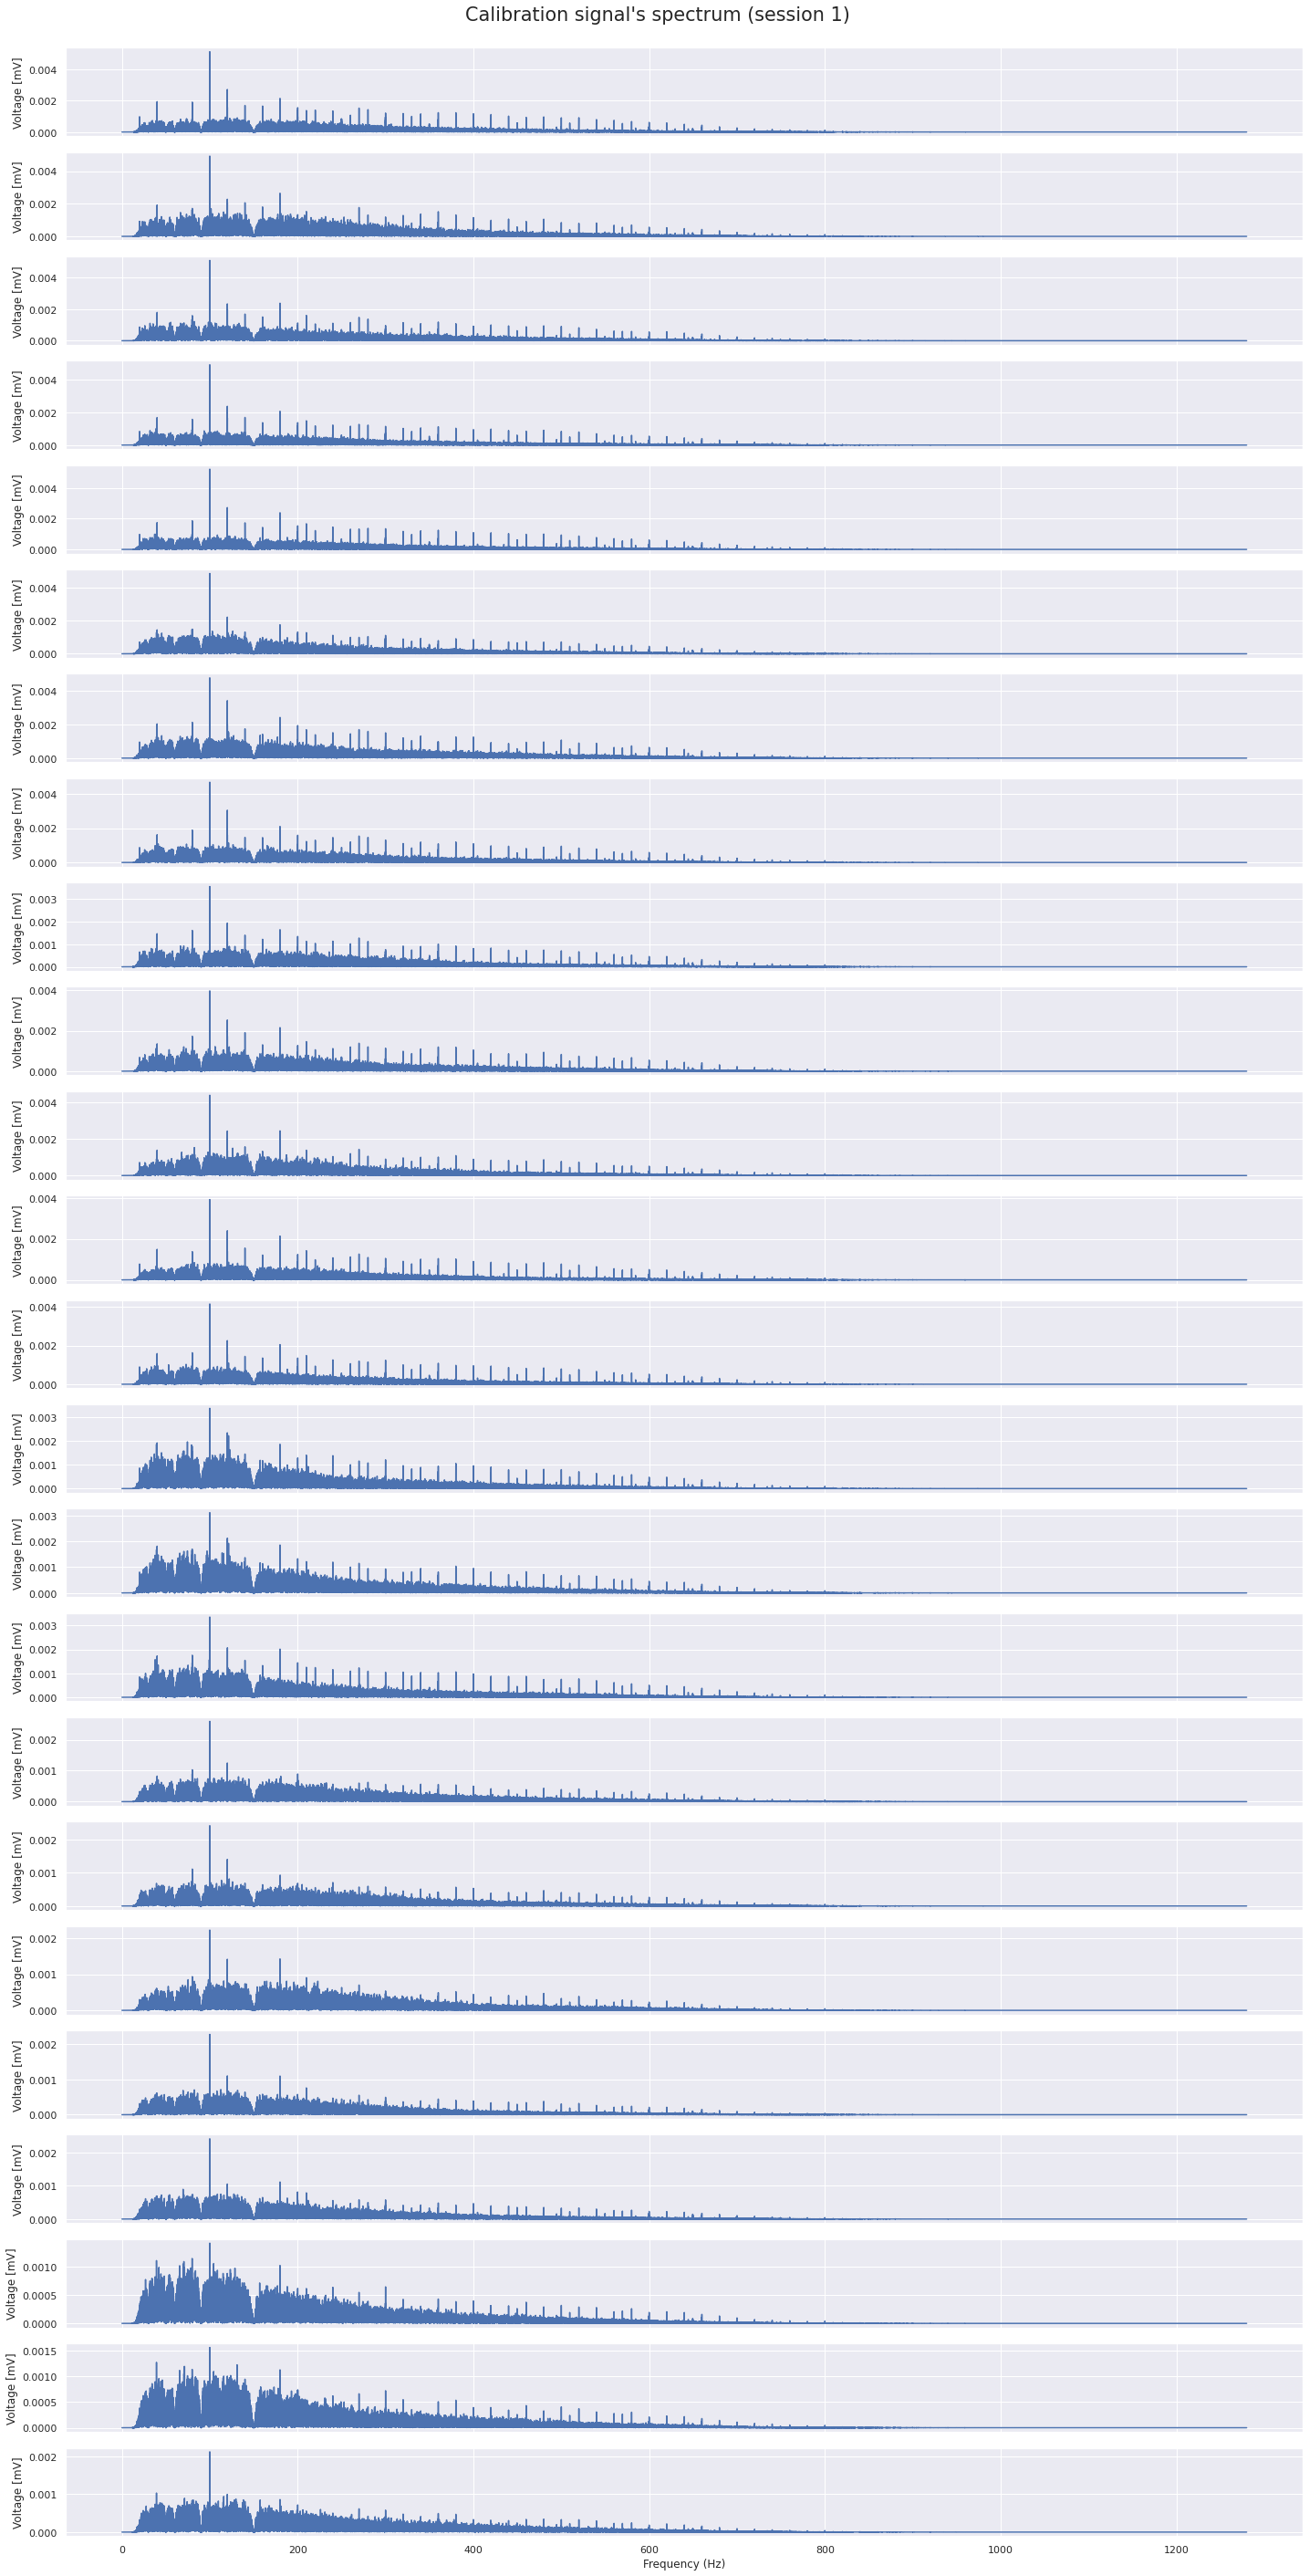

In [4]:
semg_bss.plot_fft_spectrum(
    emg_calib_s1,
    fs=RE_FS,
    title="Calibration signal's spectrum (session 1)",
    fig_size=(20, 40)
)

The first step is signal extension: since we have a convolutive mixture, we must extend the signal by adding delayed copies, resulting in $f_e \times M$ channels (where $M$ is the n. of channels in the original signal). In particular, we set $f_e=8$.
Then, the extended signal is centered and whitened via eigenvalue decomposition.

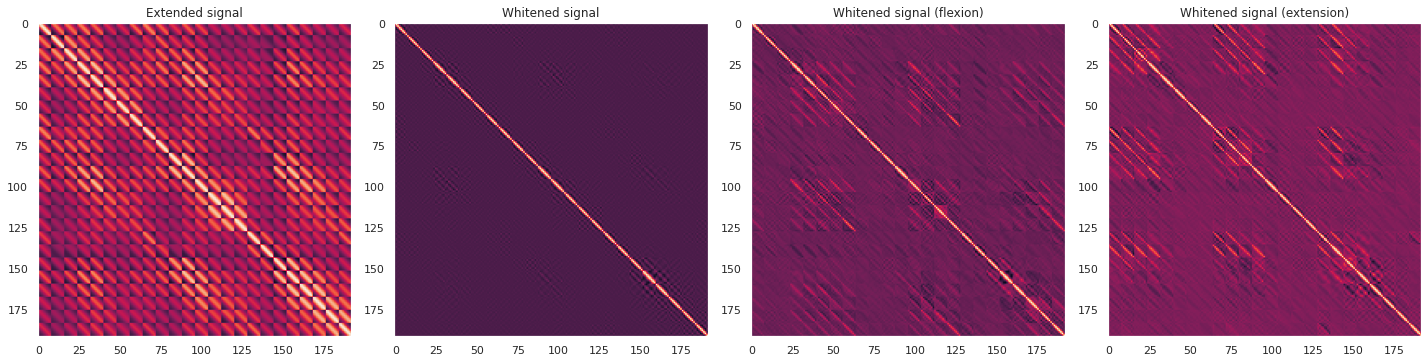

In [5]:
f_e = 8
# Extend, center and whiten the concatenated signal
emg_ext = semg_bss.preprocessing.extend_signal(emg_calib_s1, f_e)
emg_center = semg_bss.preprocessing.center_signal(emg_ext)
emg_white, white_mtx = semg_bss.preprocessing.whiten_signal(emg_center)

# Extract gestures "flexion" and "extension"
g1_from, g1_to = next((idx_from, idx_to) for label, idx_from, idx_to in labels_calib_s1 if label == "flexion")
g1_emg = emg_calib_s1[:, g1_from:g1_to]
g2_from, g2_to = next((idx_from, idx_to) for label, idx_from, idx_to in labels_calib_s1 if label == "extension")
g2_emg = emg_calib_s1[:, g2_from:g2_to]

# Preprocess them with the pre-computed whitening matrix
tmp = semg_bss.preprocessing.extend_signal(g1_emg, f_e)
tmp = semg_bss.preprocessing.center_signal(tmp)
g1_white = white_mtx @ tmp
tmp = semg_bss.preprocessing.extend_signal(g2_emg, f_e)
tmp = semg_bss.preprocessing.center_signal(tmp)
g2_white = white_mtx @ tmp

semg_bss.plot_correlation(
    array=[emg_ext, emg_white, g1_white, g2_white],
    title=["Extended signal", "Whitened signal", "Whitened signal (flexion)", "Whitened signal (extension)"],
    n_cols=4,
    fig_size=(20, 8)
)

# Free memory
del emg_ext
del emg_center
del emg_white
del white_mtx
del tmp
del g1_emg
del g1_white
del g2_emg
del g2_white

The logic behind FastICA and source improvement is encapsulated inside the `EMGSeparator` class: let's create one using $25$ target components and $f_e=8$.

In [6]:
# emg_separator_s1 = semg_bss.EMGSeparator(
#     max_comp=MAX_COMP,
#     fs=RE_FS,
#     f_e=f_e,
#     sil_th=SIL,
#     seed=SEED
# )
emg_separator_s1 = semg_bss.EMGSeparator.load_from_file("decomp_models/emg_separator_s1_neg-entropy_2_5k.pkl")

### Training
Let's calibrate the `EMGSeparator` instance on the repeats_long signal (truncated to the first 3 gestures).

Extracted 13 MUs.


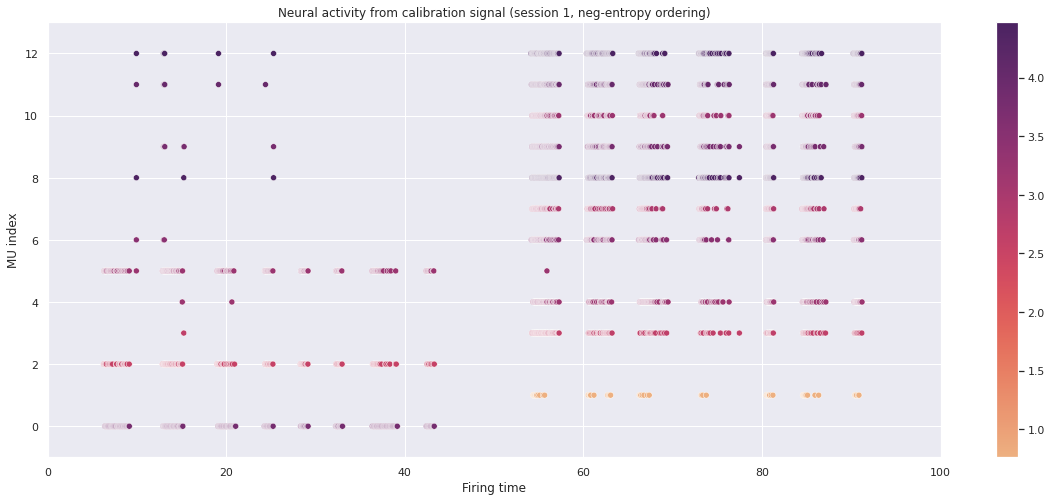

In [7]:
# Train instance on the given signal
# firings_calib_s1 = emg_separator_s1.calibrate(
#     emg_calib_s1,
#     min_spike_pps=0.5,
#     sort_by_negentropy=True
# )
firings_calib_s1 = emg_separator_s1.transform(emg_calib_s1, min_spike_pps=0.5)
print(f"Extracted {emg_separator_s1.n_mu} MUs.")

# Visualize firings
semg_bss.raster_plot(
    firings_calib_s1,
    title="Neural activity from calibration signal (session 1, neg-entropy ordering)",
    sig_len=emg_calib_s1.shape[1] / RE_FS,
    sort_by_negentropy=True,
    fig_size=(20, 8)
)

# Save instance to file
# emg_separator_s1.save_to_file(f"decomp_models/emg_separator_s1_neg-entropy_2_5k.pkl")

# Free memory
del emg_calib_s1
del labels_calib_s1
del firings_calib_s1

### Test (visual)
Let's now load the repeats_short signal. For now we'll focus on binary classification, so let's extract the extension and flexion gestures

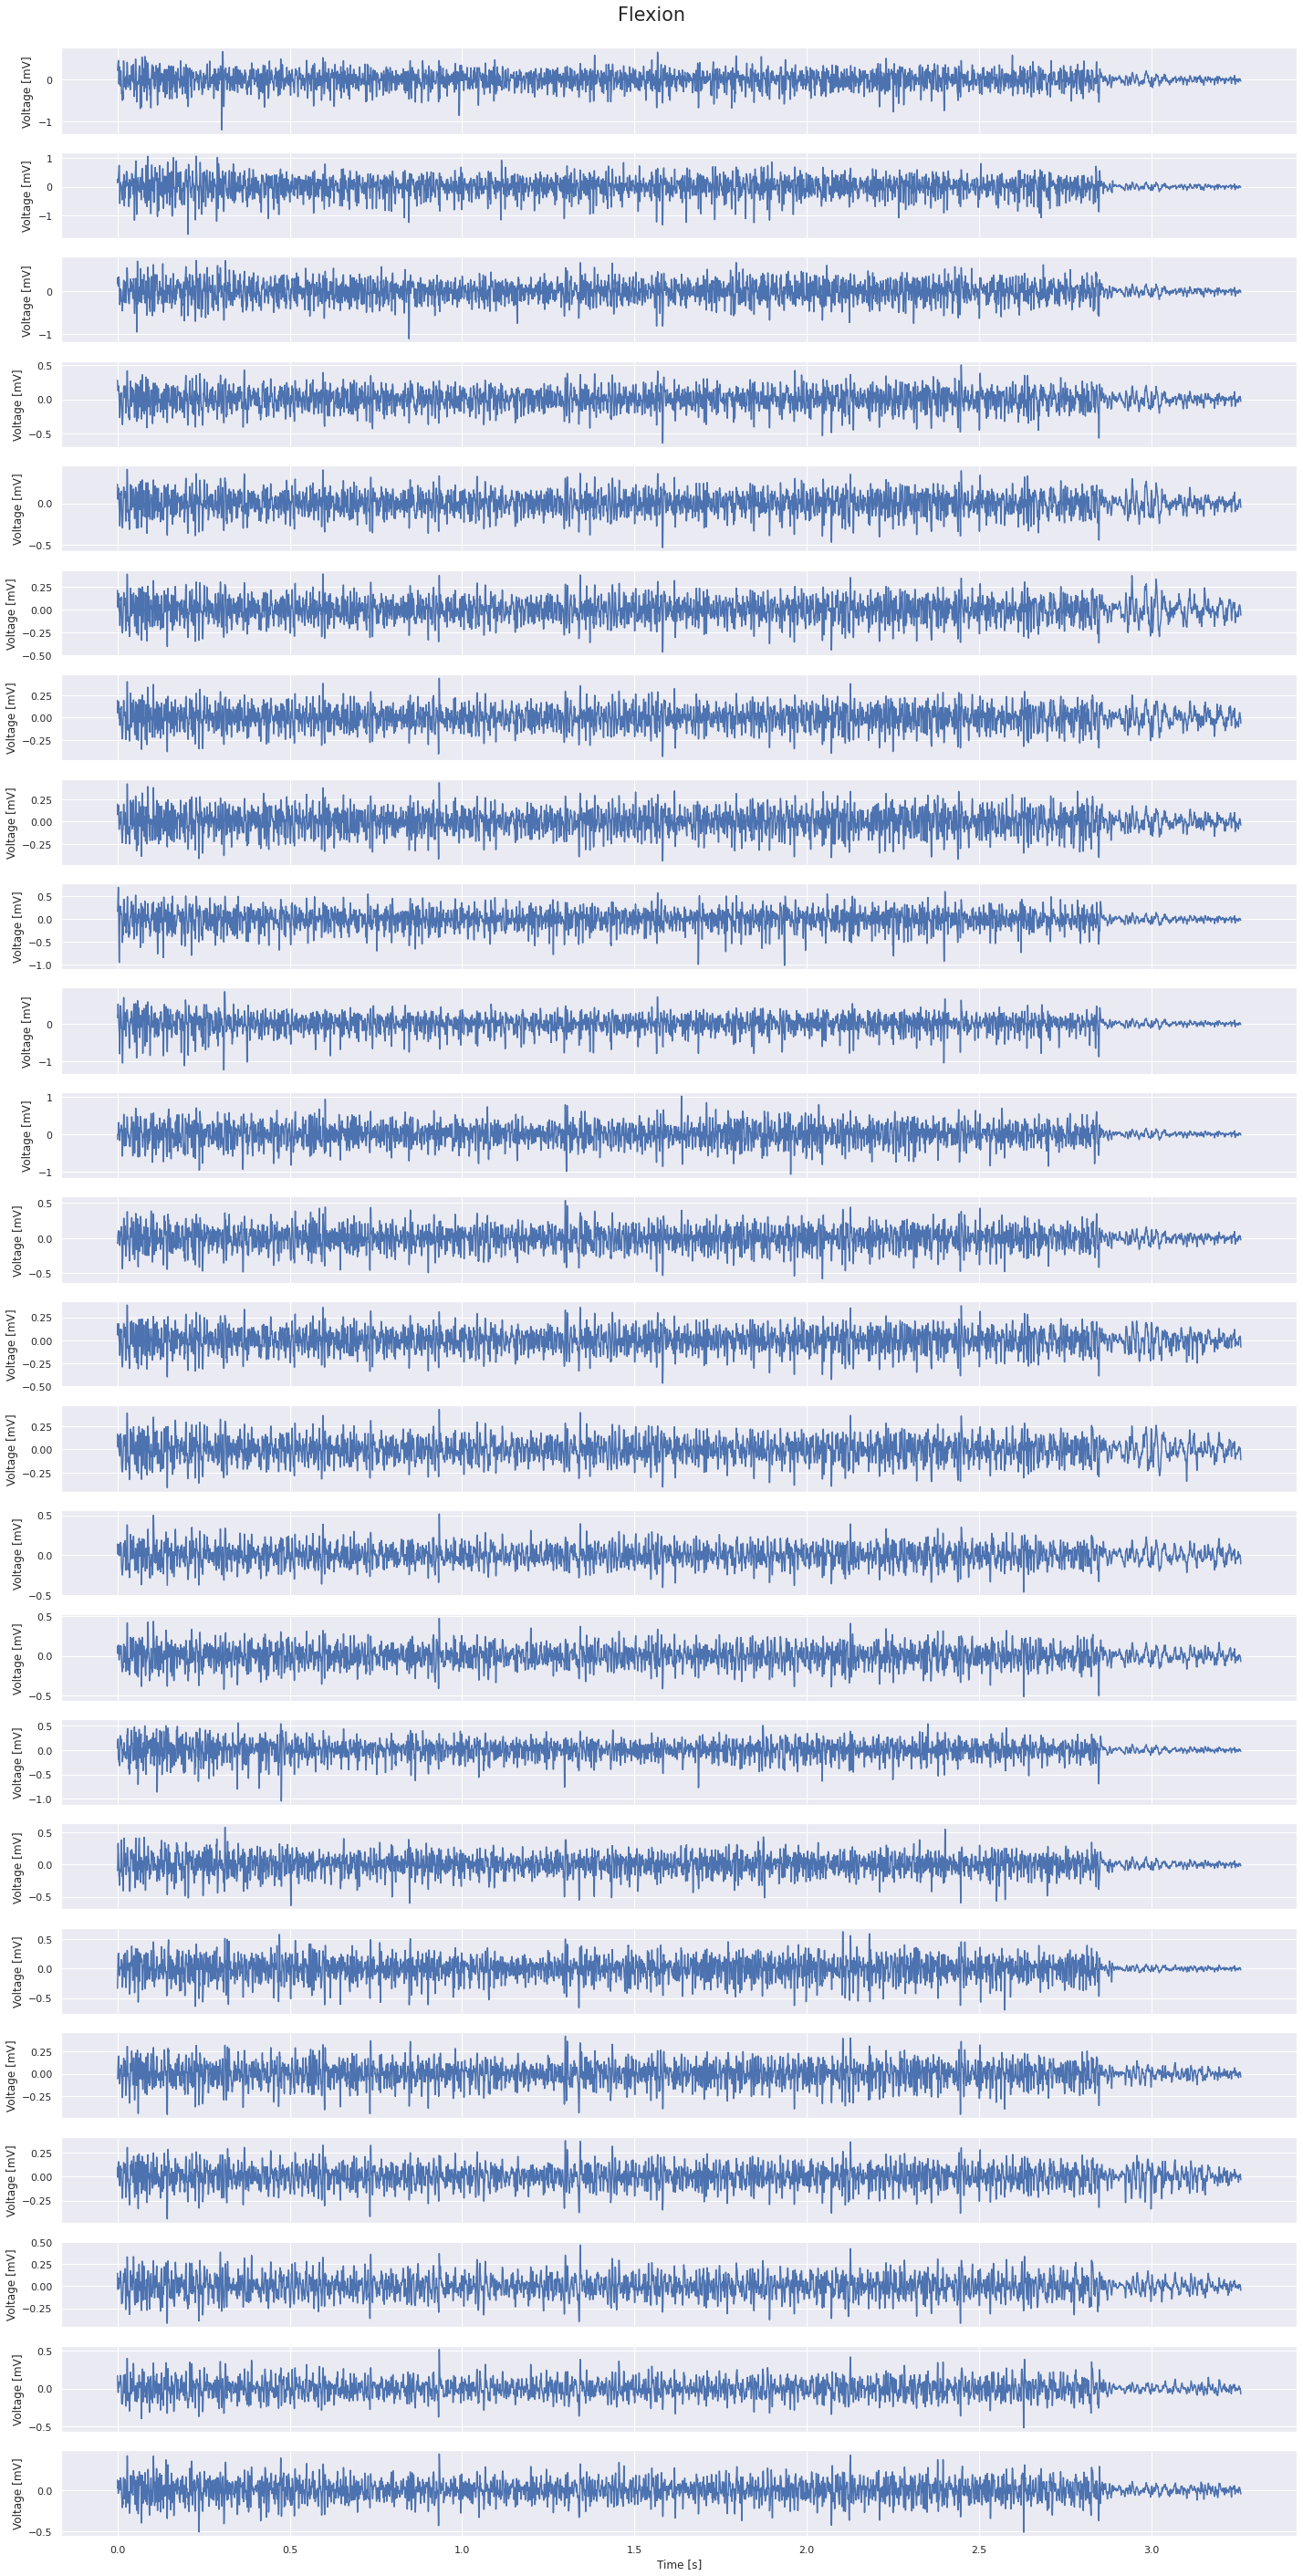

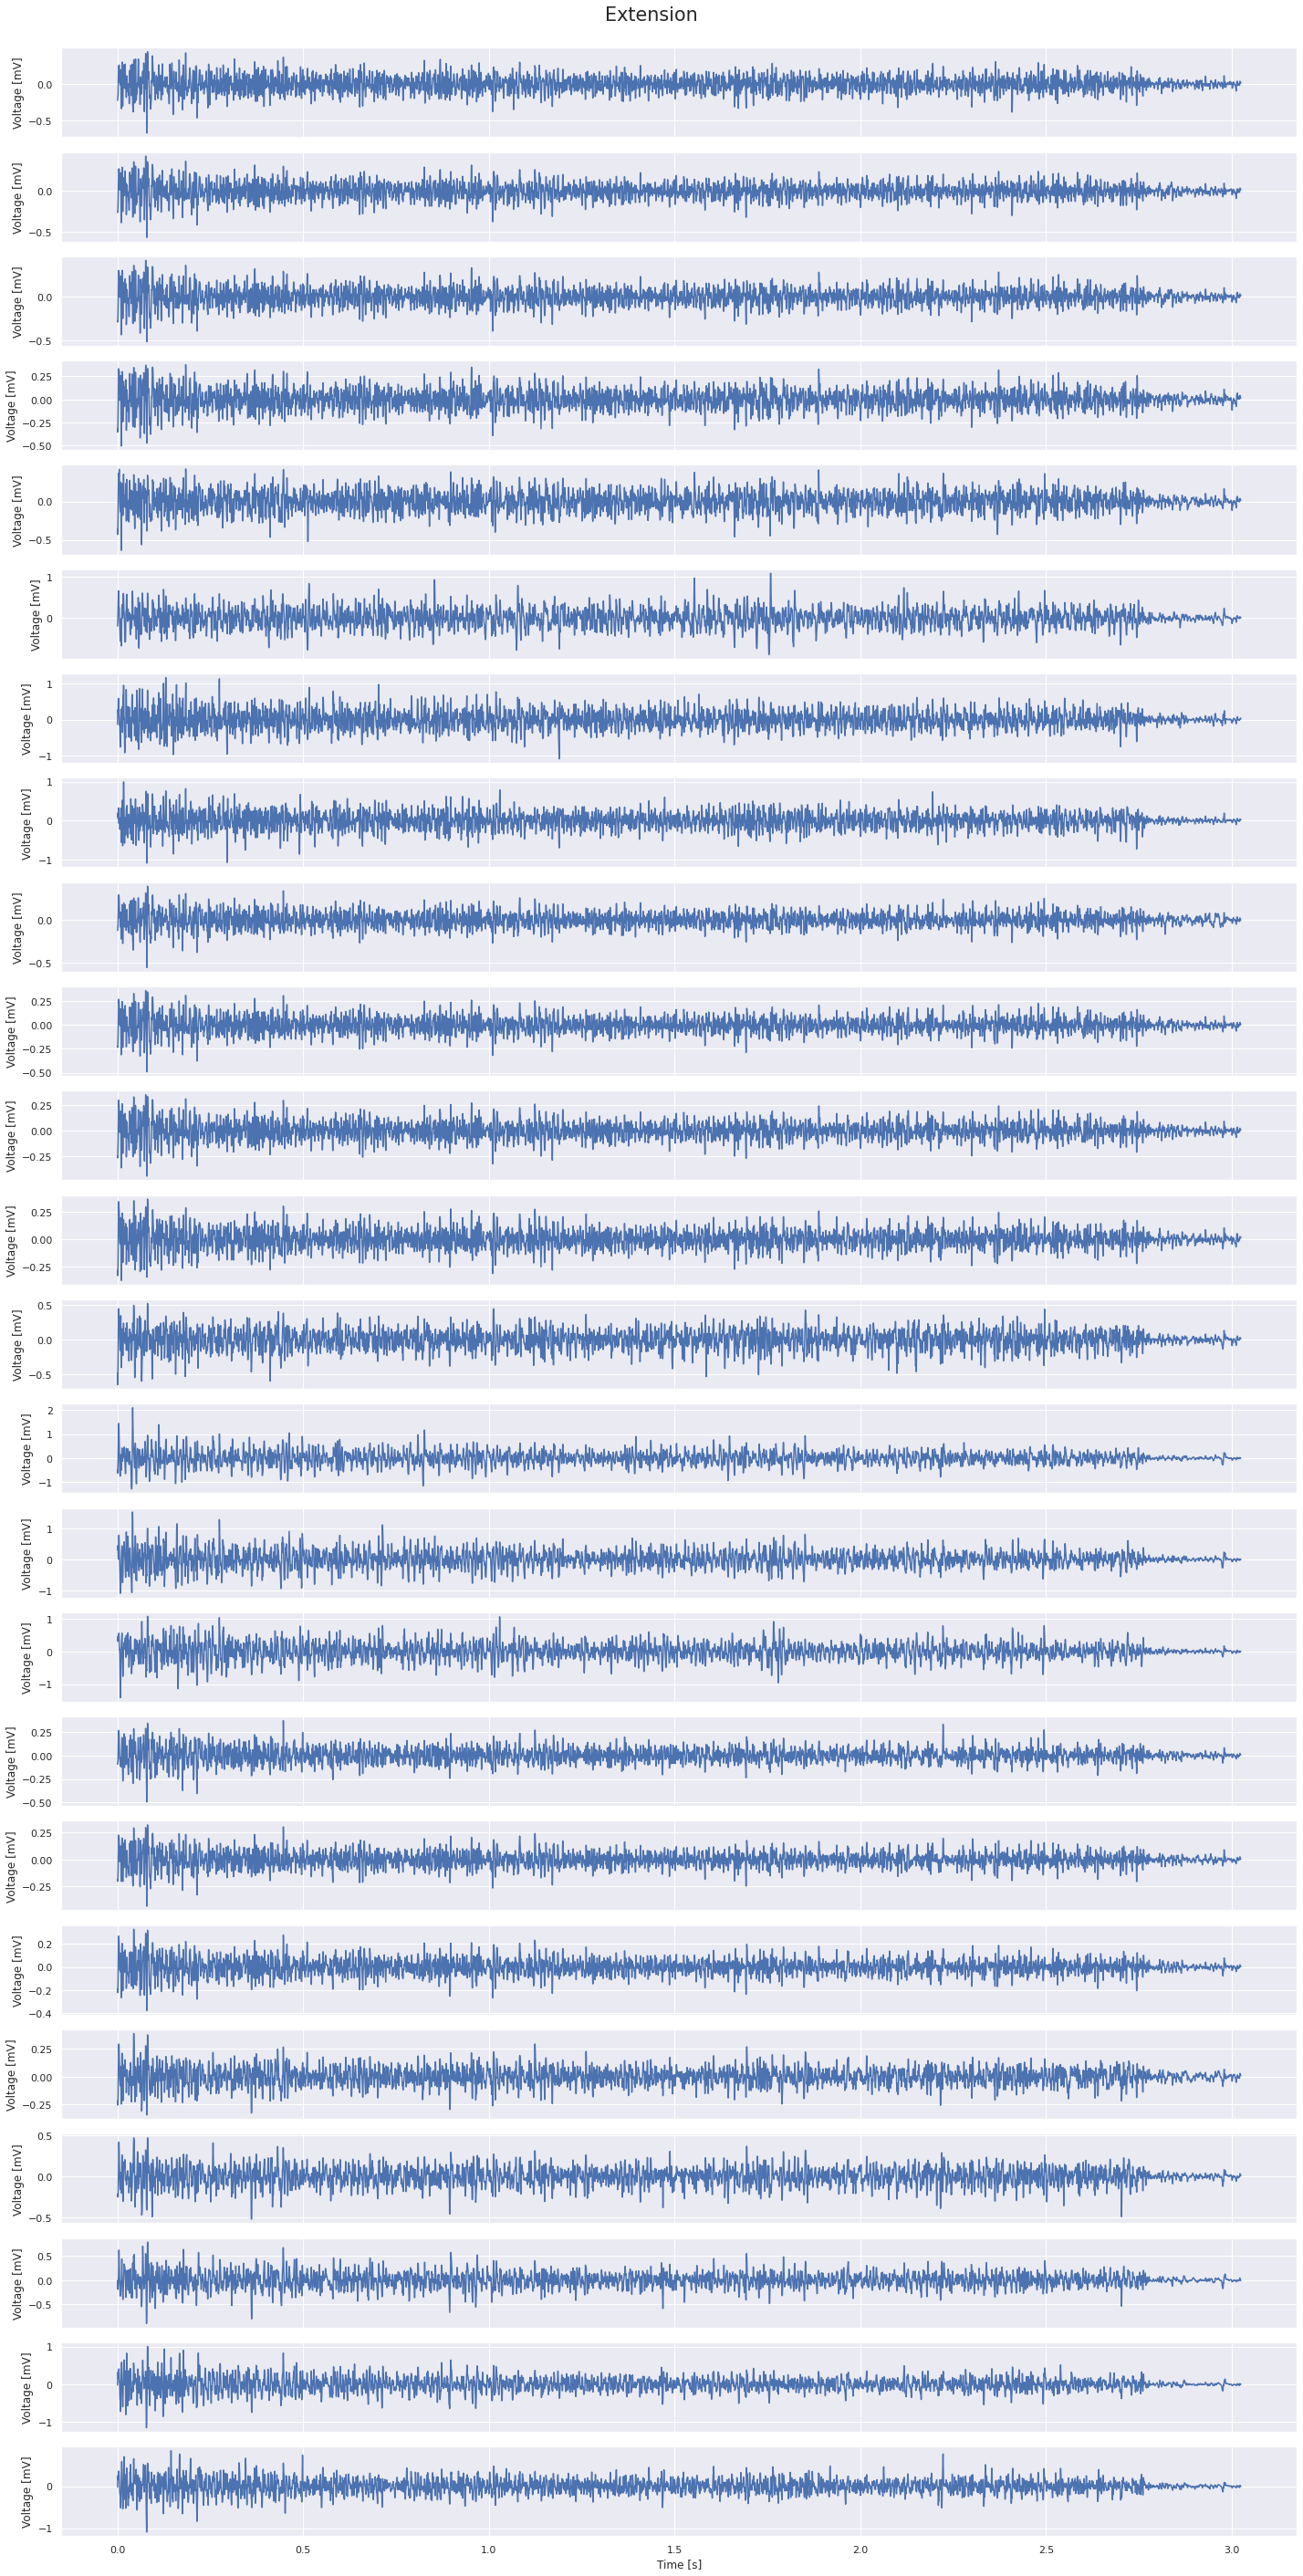

In [8]:
# Load signal
emg_test_s1, labels_test_s1 = semg_bss.put_emg.load_put_emg(
    DATA_DIR,
    subject=3,
    session=1,
    task_type="repeats_short"
)

# Filter it with 20-700 Hz band-pass filter + notch filter
emg_test_s1 = semg_bss.preprocessing.filter_signal(
    emg_test_s1,
    fs=FS_EMG,
    min_freq=20,
    max_freq=700,
    notch_freqs=[30, 50, 90, 60, 150],
    order=5
)

# Resample at 1 kHz
secs = emg_test_s1.shape[1] / FS_EMG
n_samples = int(secs * RE_FS)
emg_test_s1 = signal.decimate(emg_test_s1, FS_EMG // RE_FS, axis=1)
for i in range(len(labels_test_s1)):
    # Get boundaries for current label
    l, old_from, old_to = labels_test_s1[i]
    # Convert them to new sampling frequency
    new_from = int(old_from / FS_EMG * RE_FS)
    new_to = int(old_to / FS_EMG * RE_FS)
    # Save them
    labels_test_s1[i] = (l, new_from, new_to)

# Extract gesture "flexion"
g1_from, g1_to = next((idx_from, idx_to) for label, idx_from, idx_to in labels_test_s1 if label == "flexion")
g1_emg = emg_test_s1[:, g1_from:g1_to]
semg_bss.plot_signal(
    g1_emg,
    fs=RE_FS,
    title="Flexion",
    fig_size=(20, 40)
)

# Extract gesture "extension"
g2_from, g2_to = next((idx_from, idx_to) for label, idx_from, idx_to in labels_test_s1 if label == "extension")
g2_emg = emg_test_s1[:, g2_from:g2_to]
semg_bss.plot_signal(
    g2_emg,
    fs=RE_FS,
    title="Extension",
    fig_size=(20, 40)
)

Let's decompose the two signals with the model trained previously.

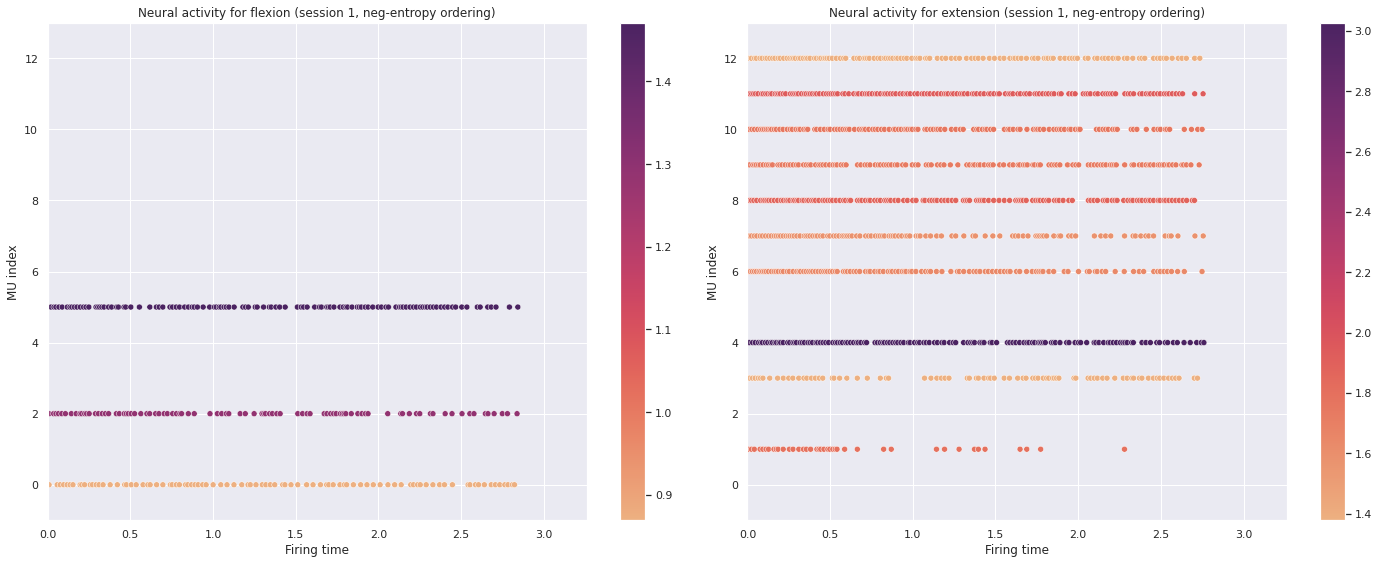

In [9]:
# Extract firings
g1_firings = emg_separator_s1.transform(g1_emg)
g2_firings = emg_separator_s1.transform(g2_emg)

semg_bss.raster_plot(
    firings=[g1_firings, g2_firings],
    title=["Neural activity for flexion (session 1, neg-entropy ordering)", "Neural activity for extension (session 1, neg-entropy ordering)"],
    sig_len=g1_emg.shape[1] / RE_FS,
    sort_by_negentropy=True,
    n_cols=2,
    fig_size=(20, 8)
)

# Free memory
del emg_test_s1
del labels_test_s1
del g1_emg
del g2_emg
del g1_firings
del g2_firings

As we can see the order of active MUs remains consistent with the calibration signal.

Now let's load the sample from session 2.

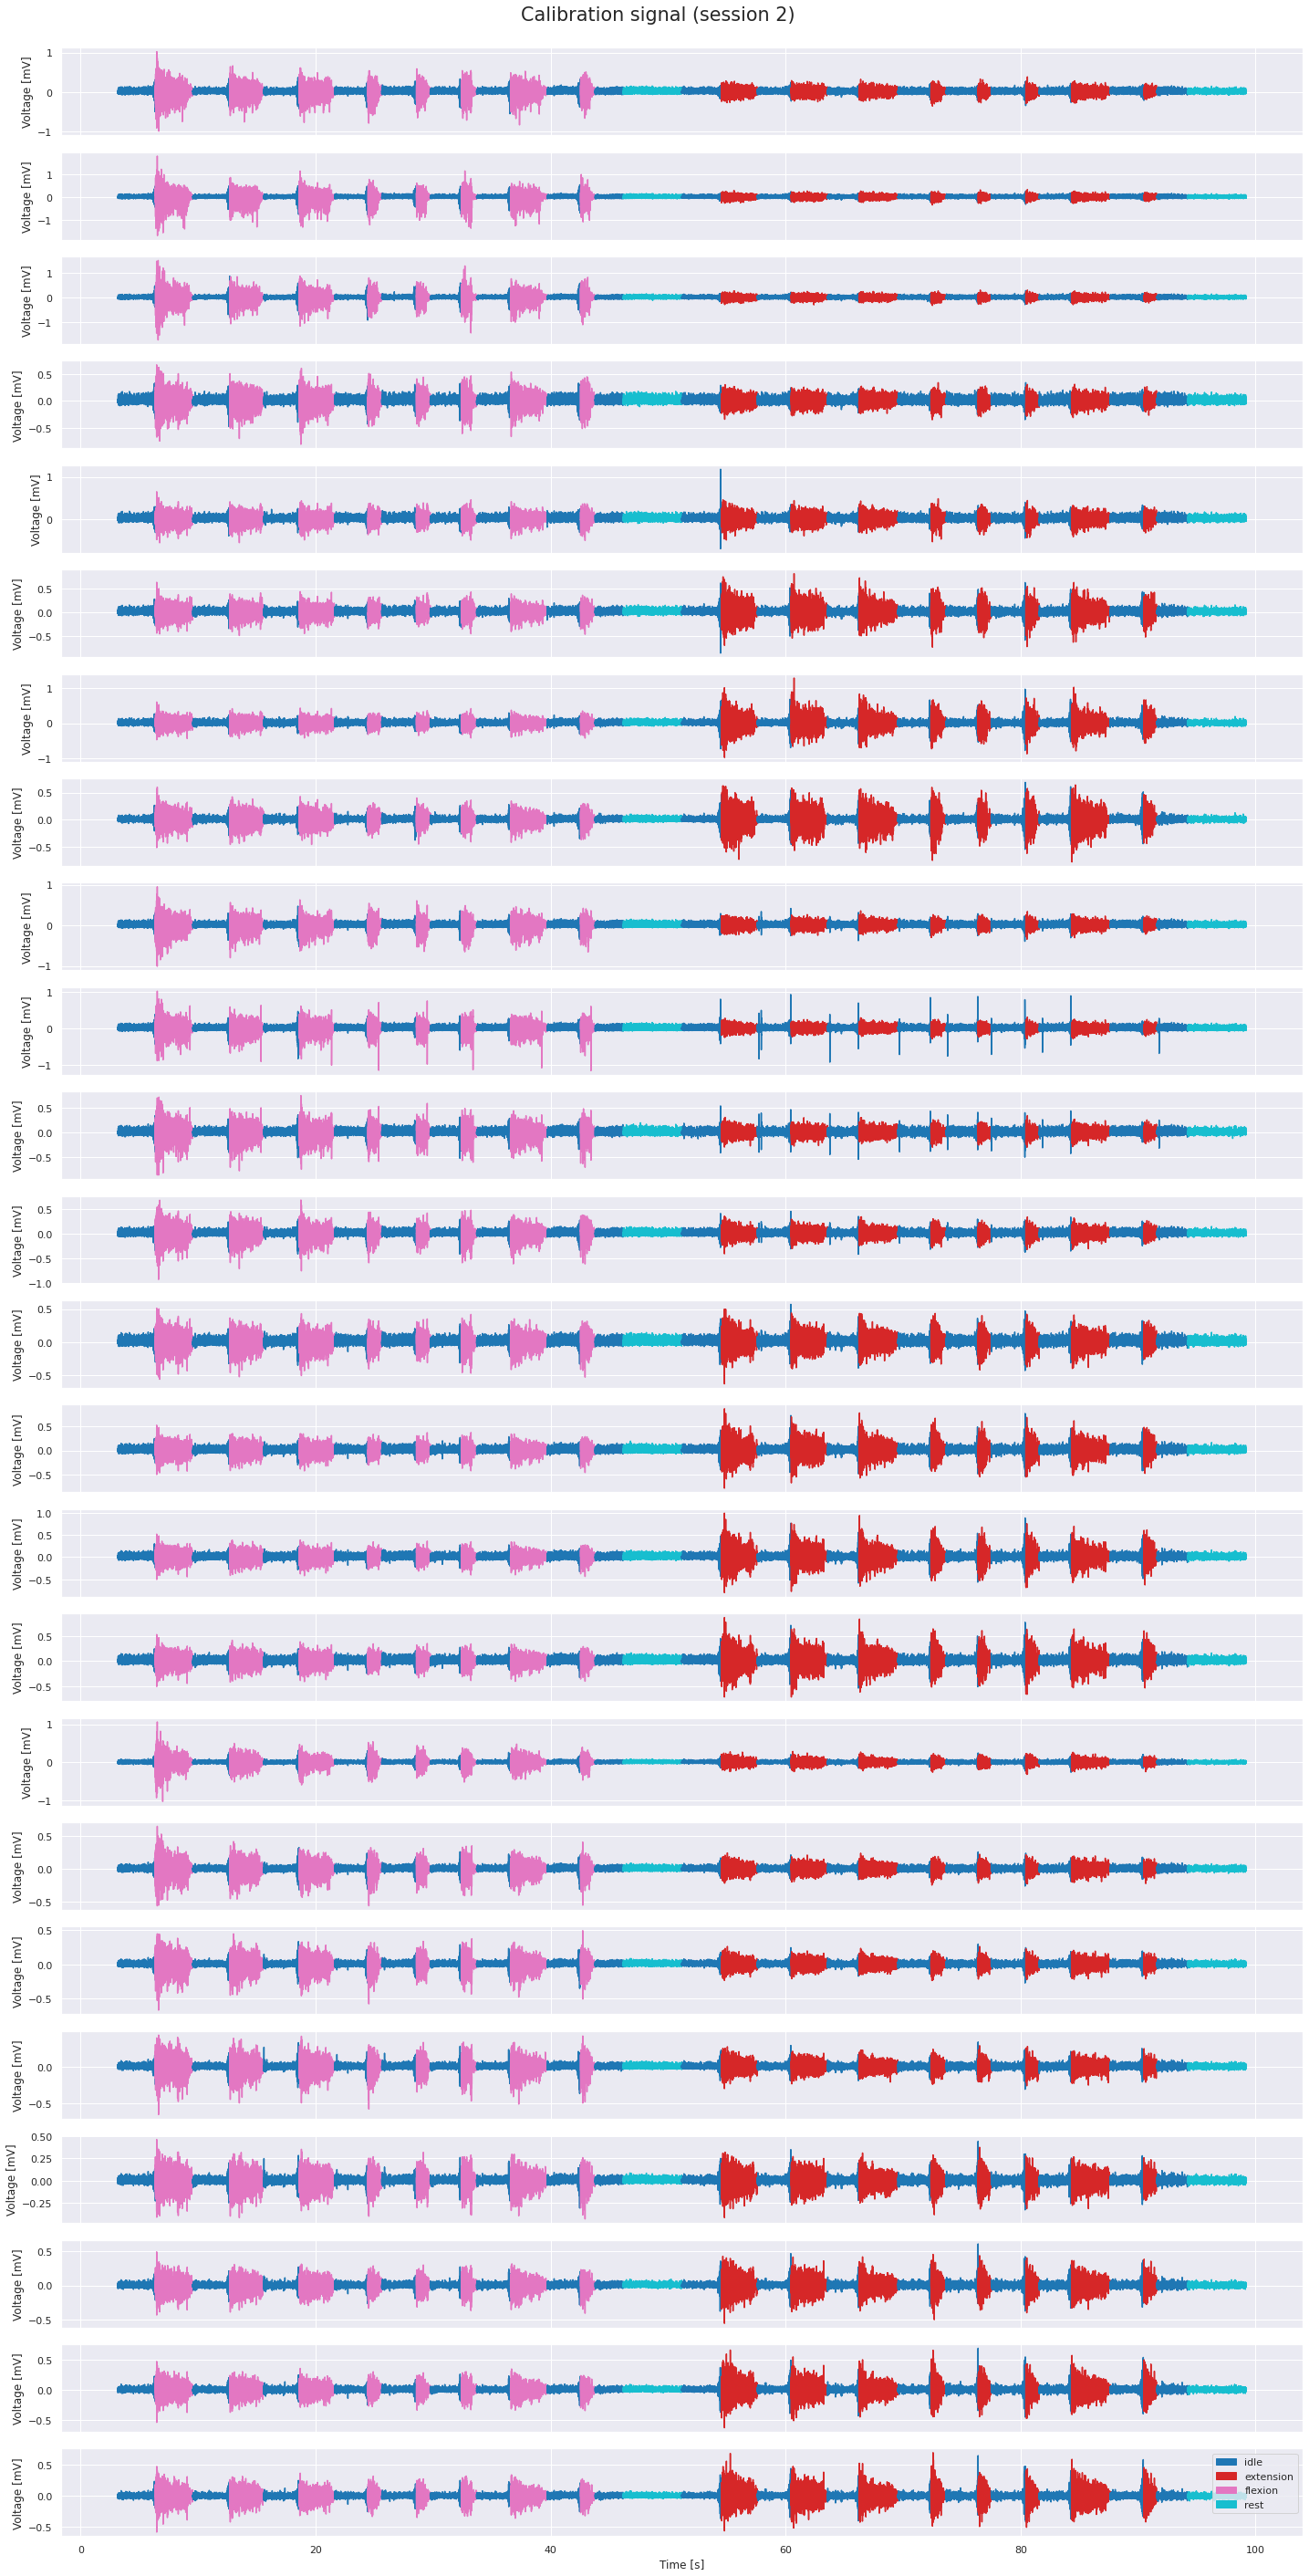

In [10]:
# Load signal
emg_calib_s2, labels_calib_s2 = semg_bss.put_emg.load_put_emg(
    DATA_DIR,
    subject=3,
    session=2,
    task_type="repeats_long"
)

# Filter it with 20-700 Hz band-pass filter + notch filter
emg_calib_s2 = semg_bss.preprocessing.filter_signal(
    emg_calib_s2,
    fs=FS_EMG,
    min_freq=20,
    max_freq=700,
    notch_freqs=[30, 50, 90, 60, 150],
    order=5
)

# Resample at 2.5 kHz
secs = emg_calib_s2.shape[1] / FS_EMG
n_samples = int(secs * RE_FS)
emg_calib_s2 = signal.decimate(emg_calib_s2, FS_EMG // RE_FS, axis=1)
for i in range(len(labels_calib_s2)):
    # Get boundaries for current label
    l, old_from, old_to = labels_calib_s2[i]
    # Convert them to new sampling frequency
    new_from = int(old_from / FS_EMG * RE_FS)
    new_to = int(old_to / FS_EMG * RE_FS)
    # Save them
    labels_calib_s2[i] = (l, new_from, new_to)

# Cut it
cut_from = 50 * RE_FS
cut_to = 150 * RE_FS
emg_calib_s2 = emg_calib_s2[:, cut_from:cut_to]
labels_calib_s2 = [(l, l_from - cut_from, l_to - cut_to) for l, l_from, l_to in labels_calib_s2 if l_from >= cut_from and l_to < cut_to]

# Plot it
semg_bss.plot_signal(
    emg_calib_s2,
    fs=RE_FS,
    title="Calibration signal (session 2)",
    labels=labels_calib_s2,
    fig_size=(20, 40)
)

Let's calibrate a second model on the new signal.

Extracted 10 MUs.


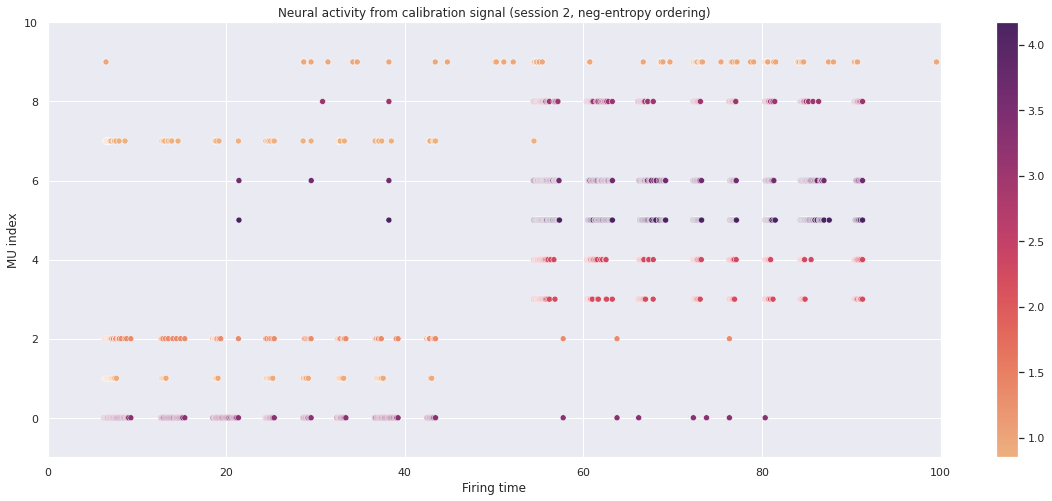

In [11]:
# Create instance
# emg_separator_s2 = semg_bss.EMGSeparator(
#     max_comp=MAX_COMP,
#     fs=RE_FS,
#     f_e=f_e,
#     sil_th=SIL,
#     seed=SEED
# )
emg_separator_s2 = semg_bss.EMGSeparator.load_from_file(f"decomp_models/emg_separator_s2_neg-entropy_2_5k.pkl")

# Train instance on the given signal
# firings_calib_s2 = emg_separator_s2.calibrate(
#     emg_calib_s2,
#     min_spike_pps=0.5,
#     sort_by_negentropy=True
# )
firings_calib_s2 = emg_separator_s2.transform(emg_calib_s2, min_spike_pps=0.5)
print(f"Extracted {emg_separator_s2.n_mu} MUs.")

# Visualize firings
semg_bss.raster_plot(
    firings_calib_s2,
    title="Neural activity from calibration signal (session 2, neg-entropy ordering)",
    sig_len=emg_calib_s2.shape[1] / RE_FS,
    sort_by_negentropy=True,
    fig_size=(20, 8)
)

# Save instance to file
# emg_separator_s2.save_to_file(f"decomp_models/emg_separator_s2_neg-entropy_2_5k.pkl")

# Free memory
del emg_calib_s2
del labels_calib_s2
del firings_calib_s2

## 4. Classification (binary, intra-session)
Let's prepare the training data for the classification task using two gestures: we'll use 500ms-long slices of all the three types of signal. Let's focus on session 1 for now.

In [12]:
slice_secs = 0.5  # = 500 ms
step_secs = 0.1  # = 100 ms
slice_len = int(slice_secs * RE_FS)
step = int(step_secs * RE_FS)
new_fs = RE_FS

# Gesture dict
gestures = ("flexion", "extension")
gesture_dict = {g: i for i, g in enumerate(gestures)}

# Use repeats_long and repeats_short for training
X_train = np.zeros(shape=(0, emg_separator_s1.n_mu * int(slice_secs * new_fs)), dtype=int)
y_train = np.zeros(shape=(0,), dtype=int)
for task_type in ("repeats_long", "repeats_short"):
    # Load signal
    emg, labels = semg_bss.put_emg.load_put_emg(
        DATA_DIR,
        subject=3,
        session=1,
        task_type=task_type
    )

    # Filter it with 20-700 Hz band-pass filter + notch filter
    emg = semg_bss.preprocessing.filter_signal(
        emg,
        fs=FS_EMG,
        min_freq=20,
        max_freq=700,
        notch_freqs=[30, 50, 90, 60, 150],
        order=5
    )
    
    # Resample at 2.5 kHz
    secs = emg.shape[1] / FS_EMG
    n_samples = int(secs * RE_FS)
    emg = signal.decimate(emg, FS_EMG // RE_FS, axis=1)
    for i in range(len(labels)):
        # Get boundaries for current label
        l, old_from, old_to = labels[i]
        # Convert them to new sampling frequency
        new_from = int(old_from / FS_EMG * RE_FS)
        new_to = int(old_to / FS_EMG * RE_FS)
        # Save them
        labels[i] = (l, new_from, new_to)
    
    for gesture in ("flexion", "extension"):
        # Extract gesture
        g_from, g_to = next((idx_from, idx_to) for label, idx_from, idx_to in labels if label == gesture)
        
        start = g_from
        while start < g_to - slice_len:
            cur_slice = emg[:, start:start + slice_len]
            firings = emg_separator_s1.transform(cur_slice, min_spike_pps=0)
            
            X_train = np.concatenate([
                X_train,
                semg_bss.df_to_dense(
                    firings,
                    emg_separator_s1.n_mu,
                    slice_secs,
                    fs=new_fs
                ).flatten().reshape(1, -1)
            ])
            y_train = np.concatenate([y_train, (gesture_dict[gesture],)])
            start += step

print("Shape of training data:", X_train.shape, y_train.shape)

# Use sequential for test
X_test = np.zeros(shape=(0, emg_separator_s1.n_mu * int(slice_secs * new_fs)), dtype=int)
y_test = np.zeros(shape=(0,), dtype=int)
for task_type in ("sequential",):
    # Load signal
    emg, labels = semg_bss.put_emg.load_put_emg(
        DATA_DIR,
        subject=3,
        session=1,
        task_type=task_type
    )

    # Filter it with 20-700 Hz band-pass filter + notch filter
    emg = semg_bss.preprocessing.filter_signal(
        emg,
        fs=FS_EMG,
        min_freq=20,
        max_freq=700,
        notch_freqs=[30, 50, 90, 60, 150],
        order=5
    )
    
    # Resample at 2.5 kHz
    secs = emg.shape[1] / FS_EMG
    n_samples = int(secs * RE_FS)
    emg = signal.decimate(emg, FS_EMG // RE_FS, axis=1)
    for i in range(len(labels)):
        # Get boundaries for current label
        l, old_from, old_to = labels[i]
        # Convert them to new sampling frequency
        new_from = int(old_from / FS_EMG * RE_FS)
        new_to = int(old_to / FS_EMG * RE_FS)
        # Save them
        labels[i] = (l, new_from, new_to)
    
    for gesture in ("flexion", "extension"):
        # Extract gesture
        g_from, g_to = next((idx_from, idx_to) for label, idx_from, idx_to in labels if label == gesture)
        
        start = g_from
        while start < g_to - slice_len:
            cur_slice = emg[:, start:start + slice_len]
            firings = emg_separator_s1.transform(cur_slice, min_spike_pps=0)
            
            X_test = np.concatenate([
                X_test,
                semg_bss.df_to_dense(
                    firings,
                    emg_separator_s1.n_mu,
                    slice_secs,
                    fs=new_fs
                ).flatten().reshape(1, -1)
            ])
            y_test = np.concatenate([y_test, (gesture_dict[gesture],)])
            start += step

print("Shape of test data:", X_test.shape, y_test.shape)

Shape of training data: (108, 16640) (108,)
Shape of test data: (49, 16640) (49,)


Let's define a simple MLP classifier and train it several times.

2022-04-14 10:22:48.933795: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-14 10:22:48.962989: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-14 10:22:48.963200: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-14 10:22:48.963919: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

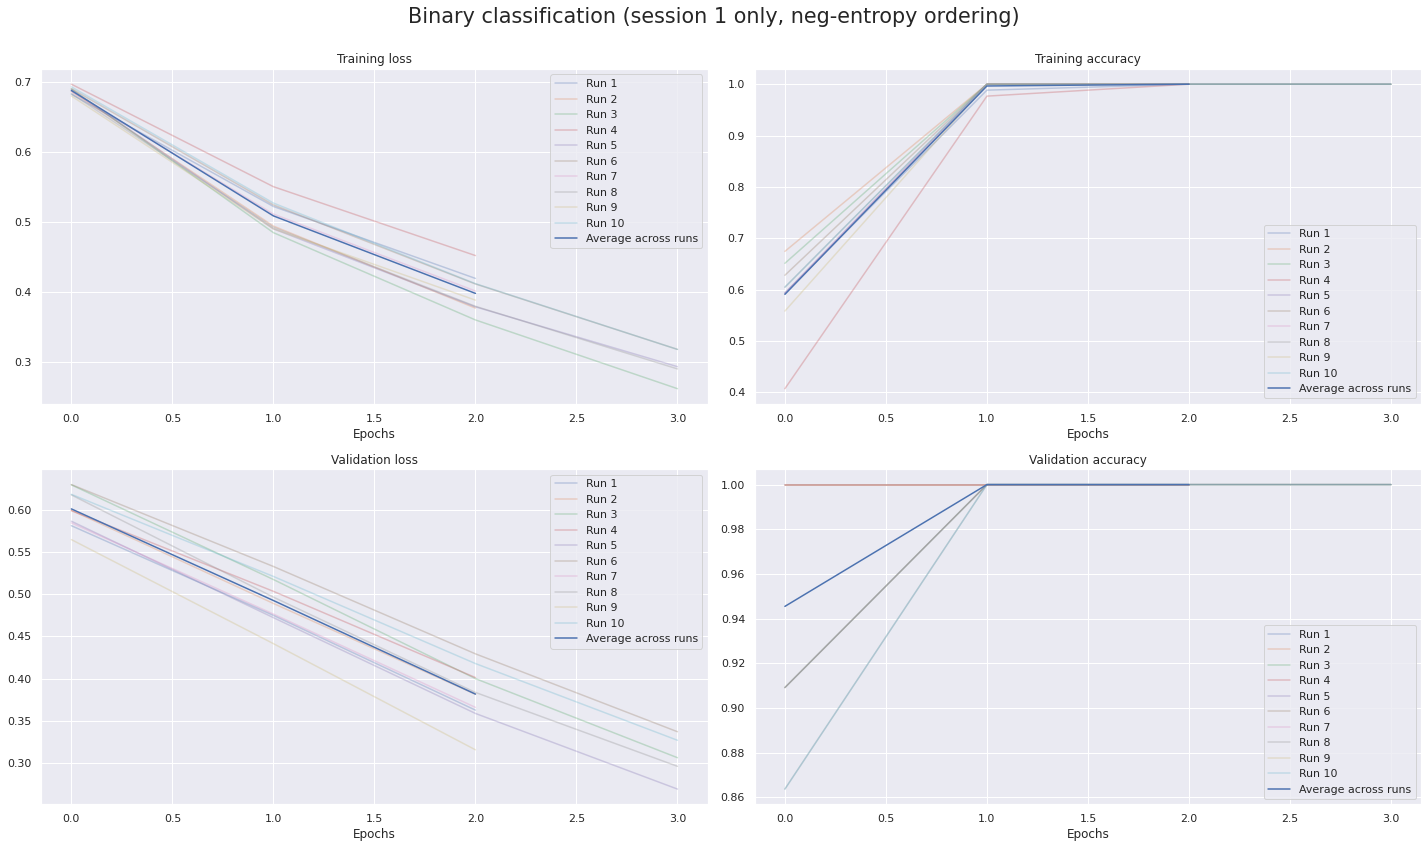

Average test accuracy: 100.00%


In [13]:
hist = {}
test_acc = []
for i in range(10):
    # Create classifier
    clf = semg_bss.build_mlp_classifier(
        n_in=X_train.shape[1],
        hidden_struct=(32,),
        n_out=1,
        optimizer="adam",
        regularize=True
    )
    # Train it
    hist[i] = clf.fit(
        X_train,
        y_train,
        batch_size=32,
        epochs=10,
        validation_split=0.2,
        callbacks=tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=2),
        verbose=0
    )
    # Test it
    test_acc.append(clf.evaluate(X_test, y_test, batch_size=32, verbose=0)[1])

semg_bss.plot_classifier_hist(hist, True, title="Binary classification (session 1 only, neg-entropy ordering)", fig_size=(20, 12))

print(f"Average test accuracy: {sum(test_acc) / len(test_acc):.2%}")

## 4. Classification (binary, inter-session)
Let's prepare the training data for the classification task using two gestures: we'll use 500ms-long slices of all the three types of signal. Let's use session 1 for training and session 2 for test.

In [14]:
slice_secs = 0.5  # = 500 ms
step_secs = 0.1  # = 100 ms
slice_len = int(slice_secs * RE_FS)
step = int(step_secs * RE_FS)
new_fs = RE_FS

min_n_mu = min((emg_separator_s1.n_mu, emg_separator_s2.n_mu))

# Gesture dict
gestures = ("flexion", "extension")
gesture_dict = {g: i for i, g in enumerate(gestures)}

# Use repeats_long and repeats_short for training
X_train = np.zeros(shape=(0, min_n_mu * int(slice_secs * new_fs)), dtype=int)
y_train = np.zeros(shape=(0,), dtype=int)
for task_type in ("repeats_long", "repeats_short", "sequential"):
    # Load signal
    emg, labels = semg_bss.put_emg.load_put_emg(
        DATA_DIR,
        subject=3,
        session=1,
        task_type=task_type
    )

    # Filter it with 20-700 Hz band-pass filter + notch filter
    emg = semg_bss.preprocessing.filter_signal(
        emg,
        fs=FS_EMG,
        min_freq=20,
        max_freq=700,
        notch_freqs=[30, 50, 90, 60, 150],
        order=5
    )
    
    # Resample at 2.5 kHz
    secs = emg.shape[1] / FS_EMG
    n_samples = int(secs * RE_FS)
    emg = signal.decimate(emg, FS_EMG // RE_FS, axis=1)
    for i in range(len(labels)):
        # Get boundaries for current label
        l, old_from, old_to = labels[i]
        # Convert them to new sampling frequency
        new_from = int(old_from / FS_EMG * RE_FS)
        new_to = int(old_to / FS_EMG * RE_FS)
        # Save them
        labels[i] = (l, new_from, new_to)
    
    for gesture in ("flexion", "extension"):
        # Extract gesture
        g_from, g_to = next((idx_from, idx_to) for label, idx_from, idx_to in labels if label == gesture)
        
        start = g_from
        while start < g_to - slice_len:
            cur_slice = emg[:, start:start + slice_len]
            firings = emg_separator_s1.transform(cur_slice, min_spike_pps=0)
            
            X_train = np.concatenate([
                X_train,
                semg_bss.df_to_dense(
                    firings,
                    min_n_mu,
                    slice_secs,
                    fs=new_fs
                ).flatten().reshape(1, -1)
            ])
            y_train = np.concatenate([y_train, (gesture_dict[gesture],)])
            start += step

print("Shape of training data:", X_train.shape, y_train.shape)

# Use sequential for test
X_test = np.zeros(shape=(0, min_n_mu * int(slice_secs * new_fs)), dtype=int)
y_test = np.zeros(shape=(0,), dtype=int)
for task_type in ("repeats_long", "repeats_short", "sequential"):
    # Load signal
    emg, labels = semg_bss.put_emg.load_put_emg(
        DATA_DIR,
        subject=3,
        session=2,
        task_type=task_type
    )

    # Filter it with 20-700 Hz band-pass filter + notch filter
    emg = semg_bss.preprocessing.filter_signal(
        emg,
        fs=FS_EMG,
        min_freq=20,
        max_freq=700,
        notch_freqs=[30, 50, 90, 60, 150],
        order=5
    )
    
    # Resample at 2.5 kHz
    secs = emg.shape[1] / FS_EMG
    n_samples = int(secs * RE_FS)
    emg = signal.decimate(emg, FS_EMG // RE_FS, axis=1)
    for i in range(len(labels)):
        # Get boundaries for current label
        l, old_from, old_to = labels[i]
        # Convert them to new sampling frequency
        new_from = int(old_from / FS_EMG * RE_FS)
        new_to = int(old_to / FS_EMG * RE_FS)
        # Save them
        labels[i] = (l, new_from, new_to)
    
    for gesture in ("flexion", "extension"):
        # Extract gesture
        g_from, g_to = next((idx_from, idx_to) for label, idx_from, idx_to in labels if label == gesture)
        
        start = g_from
        while start < g_to - slice_len:
            cur_slice = emg[:, start:start + slice_len]
            firings = emg_separator_s2.transform(cur_slice, min_spike_pps=0)
            
            X_test = np.concatenate([
                X_test,
                semg_bss.df_to_dense(
                    firings,
                    min_n_mu,
                    slice_secs,
                    fs=new_fs
                ).flatten().reshape(1, -1)
            ])
            y_test = np.concatenate([y_test, (gesture_dict[gesture],)])
            start += step

print("Shape of test data:", X_test.shape, y_test.shape)

Shape of training data: (157, 12800) (157,)
Shape of test data: (159, 12800) (159,)


Let's define a simple MLP classifier and train it several times.

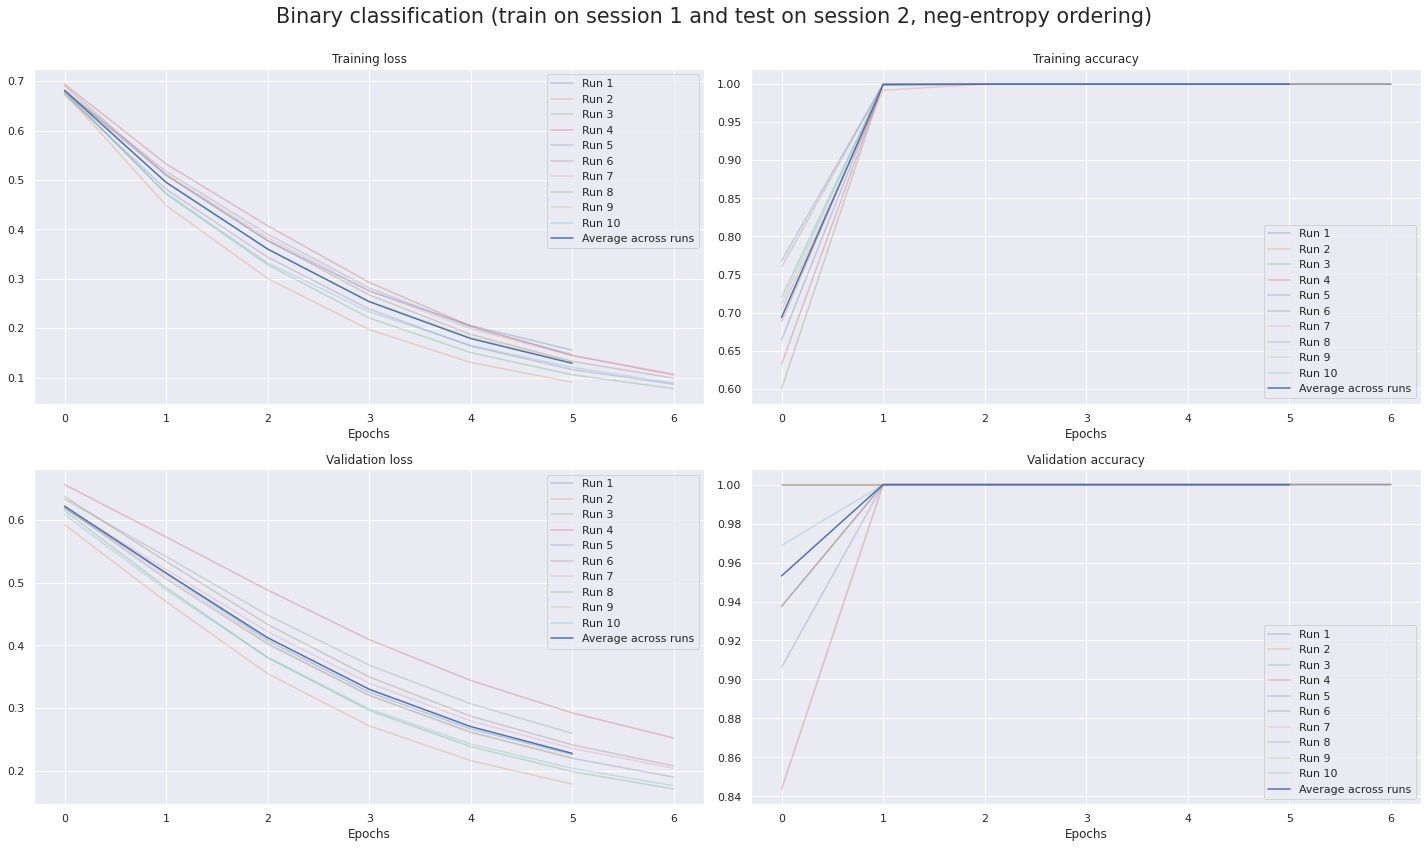

Average test accuracy: 83.58%


In [15]:
hist = {}
test_acc = []
for i in range(10):
    # Create classifier
    clf = semg_bss.build_mlp_classifier(
        n_in=X_train.shape[1],
        hidden_struct=(32,),
        n_out=1,
        optimizer="adam",
        regularize=True
    )
    # Train it
    hist[i] = clf.fit(
        X_train,
        y_train,
        batch_size=32,
        epochs=20,
        validation_split=0.2,
        callbacks=tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=5),
        verbose=0
    )
    # Test it
    test_acc.append(clf.evaluate(X_test, y_test, batch_size=32, verbose=0)[1])

semg_bss.plot_classifier_hist(hist, True, title="Binary classification (train on session 1 and test on session 2, neg-entropy ordering)", fig_size=(20, 12))

print(f"Average test accuracy: {sum(test_acc) / len(test_acc):.2%}")